In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from copy import deepcopy
import random
import numpy as np

def seed_everything(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(0)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = dsets.CIFAR10(
    root='./data/CIFAR10/',
    train=False,
    transform=transform_test
)

Files already downloaded and verified


In [2]:
# Define old and new classes
old_classes = [0, 1, 2, 3, 4]  # 'airplane', 'automobile', 'bird', 'cat', 'deer'
new_classes = [5, 6, 7, 8, 9]  # 'dog', 'frog', 'horse', 'ship', 'truck'

# Filter classes function
def filter_classes(dataset, include_classes):
    indices = [i for i, label in enumerate(dataset.targets) if label in include_classes]
    dataset.data = dataset.data[indices]
    dataset.targets = np.array(dataset.targets)[indices].tolist()
    return dataset

# Get subset function
def get_subset(dataset, class_indices, num_samples_per_class=10):
    indices = []
    for class_idx in class_indices:
        class_indices_list = [i for i, label in enumerate(dataset.targets) if label == class_idx]
        if len(class_indices_list) < num_samples_per_class:
            raise ValueError(f"Class {class_idx} has fewer than {num_samples_per_class} samples.")
        indices.extend(random.sample(class_indices_list, num_samples_per_class))
    dataset.data = dataset.data[indices]
    dataset.targets = np.array(dataset.targets)[indices].tolist()
    return dataset



# Train data에서 validation set 분리
train_indices, val_indices = train_test_split(np.arange(len(train_dataset.targets)), test_size=0.1, stratify=train_dataset.targets)

# Train data and targets update
train_data = train_dataset.data[train_indices]
train_targets = np.array(train_dataset.targets)[train_indices].tolist()

# Validation data and targets
val_data = train_dataset.data[val_indices]
val_targets = np.array(train_dataset.targets)[val_indices].tolist()

# Train dataset 업데이트
train_dataset.data = train_data
train_dataset.targets = train_targets

# Validation dataset 생성
validation_dataset = deepcopy(train_dataset)
validation_dataset.data = val_data
validation_dataset.targets = val_targets

# Validation DataLoader
val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4
)

# 전체 train dataset (validation set 제외)으로 full_train_dataset 생성
full_train_dataset = dsets.CIFAR10(
    root='./data/CIFAR10/',
    train=True,
    transform=transform_train,
    download=True
)
full_train_dataset.data = train_data
full_train_dataset.targets = train_targets

# Filter dataset for new classes
new_class_dataset = filter_classes(deepcopy(full_train_dataset), new_classes)

# old class에서 10개씩 샘플 뽑아서 old class에 대한 train set 만들기
old_class_subset = get_subset(filter_classes(deepcopy(full_train_dataset), old_classes), old_classes, num_samples_per_class=10)

# Combine new class dataset and old class subset
combined_data = np.concatenate((new_class_dataset.data, old_class_subset.data), axis=0)
combined_targets = new_class_dataset.targets + old_class_subset.targets
combined_dataset = deepcopy(full_train_dataset)
combined_dataset.data = combined_data
combined_dataset.targets = combined_targets

# Verify combined dataset
print("Train dataset class distribution:", np.bincount(combined_dataset.targets))


Files already downloaded and verified
Train dataset class distribution: [  10   10   10   10   10 4500 4500 4500 4500 4500]


In [3]:
train_loader = torch.utils.data.DataLoader(
    dataset=combined_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)


test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4
)

In [4]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    # ResNet Block
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, temp=1.0):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # -> 1
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # num_blocks = 2 -> 2*2 = 4
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # num_blocks = 2 -> 4
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # num_blocks = 2 -> 4
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # num_blocks = 2 -> 4
        self.fc = nn.Linear(512 * block.expansion, num_classes) # -> 1
        # 총 18개 layers -> ResNet-18
        self.temp = temp

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out) / self.temp
        return out


def resnet18(temp=1.0, **kwargs):
    # 직접 만든 ResNet-18 이용
    model = ResNet(BasicBlock, [2, 2, 2, 2], temp=temp, **kwargs)
    return model

### resnet18_base.pth 성능 확인

In [6]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model2 = resnet18(num_classes=5)
model2.load_state_dict(torch.load('resnet18_base.pth'))
model2.to(device)

# Check initial performance on old classes
model2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

initial_accuracy = 100 * sum(class_correct) / sum(class_total)
print(f'Initial Total Accuracy: {initial_accuracy:.2f}%')

for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
    else:
        accuracy = 0
    print(f'Initial Accuracy of {class_name[i]}: {accuracy:.2f}%')

Initial Total Accuracy: 46.03%
Initial Accuracy of airplane: 95.20%
Initial Accuracy of automobile: 98.20%
Initial Accuracy of bird: 86.80%
Initial Accuracy of cat: 88.60%
Initial Accuracy of deer: 91.50%
Initial Accuracy of dog: 0.00%
Initial Accuracy of frog: 0.00%
Initial Accuracy of horse: 0.00%
Initial Accuracy of ship: 0.00%
Initial Accuracy of truck: 0.00%


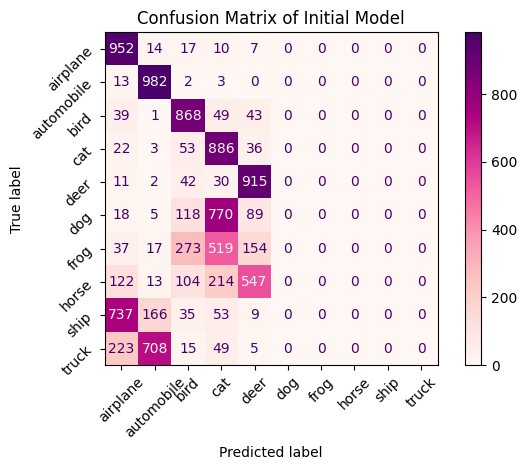

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, class_names, title):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.RdPu)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(model2, test_loader, class_names, 'Confusion Matrix of Initial Model')


In [8]:
model2.cpu()
del model2
torch.cuda.empty_cache()

In [9]:
# Load pre-trained ResNet-18 with initial 5 classes
model = resnet18(num_classes=5)
model.load_state_dict(torch.load('resnet18_base.pth'))
model = model.to(device)

# 기존 모델을 teacher model로 사용 (5개 클래스 상태에서 복사)
teacher_model = deepcopy(model)
teacher_model.eval()

# Update the model's fully connected layer to 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Feature extractor (removing the final classification layer)
feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)

In [10]:
class IncrementalLearner:
    def __init__(self, model, feature_extractor, lr=5e-5, momentum=0.9, weight_decay=2e-4, num_epochs=30, n_classes=10, temperature=2.0, alpha=0.5):
        self.model = model
        self.feature_extractor = feature_extractor
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.n_classes = n_classes
        self.temperature = temperature
        self.alpha = alpha
        self.train_accuracies = []
        self.test_accuracies = []

        # Freeze feature extractor layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def distillation_loss(self, outputs, labels, teacher_outputs, alpha, temperature):
        """
        Compute the distillation loss given student outputs, ground truth labels, teacher outputs, alpha and temperature.
        """
        # Extend teacher outputs to match the new class size
        extended_teacher_outputs = torch.zeros_like(outputs)
        extended_teacher_outputs[:, :teacher_outputs.size(1)] = teacher_outputs

        loss = nn.KLDivLoss()(F.log_softmax(outputs / temperature, dim=1),
                              F.softmax(extended_teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature) + \
               F.cross_entropy(outputs, labels) * (1. - alpha)
        return loss

    def train(self, train_loader, teacher_model, val_loader):
        self.optimizer = optim.SGD(self.model.fc.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)

        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)
                loss = self.distillation_loss(outputs, labels, teacher_outputs, self.alpha, self.temperature)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if i % 100 == 99:
                    print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                    running_loss = 0.0

            train_accuracy = 100 * correct / total
            self.train_accuracies.append(train_accuracy)

            # Evaluate on test set
            print(f"Epoch {epoch + 1} complete. Evaluating...")
            test_accuracy, class_acc = self.evaluate(val_loader)
            self.test_accuracies.append(test_accuracy)
            print(f"Train Accuracy after epoch {epoch + 1}: {train_accuracy:.2f}%")
            print(f"Valid Accuracy after epoch {epoch + 1}: {test_accuracy:.2f}%")
            for class_idx in range(self.n_classes):
                print(f"Valid Accuracy for class {class_idx}: {class_acc[class_idx]:.2f}%")

        self.plot_accuracies()

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        class_correct = [0] * self.n_classes
        class_total = [0] * self.n_classes
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for label, prediction in zip(labels, predicted):
                    if label == prediction:
                        class_correct[label] += 1
                    class_total[label] += 1

        class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(self.n_classes)]
        return 100 * correct / total, class_acc

    def plot_accuracies(self):
        epochs = range(1, self.num_epochs + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy', color='#FF33CC')
        plt.plot(epochs, self.test_accuracies, label='Valid Accuracy', color='#66FFFF')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Train and Valid Accuracies over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_state(self, file_path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_accuracies': self.train_accuracies,
            'test_accuracies': self.test_accuracies
        }, file_path)

    def load_state(self, file_path):
        checkpoint = torch.load(file_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_accuracies = checkpoint['train_accuracies']
        self.test_accuracies = checkpoint['test_accuracies']

## incrementa_learner 도입

/home/compu/anaconda3/envs/MJ/lib/python3.12/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[1, 100] loss: 0.425
[1, 200] loss: 0.354
[1, 300] loss: 0.349
Epoch 1 complete. Evaluating...
Train Accuracy after epoch 1: 57.06%
Valid Accuracy after epoch 1: 65.36%
Valid Accuracy for class 0: 45.80%
Valid Accuracy for class 1: 80.20%
Valid Accuracy for class 2: 71.20%
Valid Accuracy for class 3: 60.60%
Valid Accuracy for class 4: 81.60%
Valid Accuracy for class 5: 49.80%
Valid Accuracy for class 6: 69.40%
Valid Accuracy for class 7: 49.60%
Valid Accuracy for class 8: 76.20%
Valid Accuracy for class 9: 69.20%
[2, 100] loss: 0.341
[2, 200] loss: 0.334
[2, 300] loss: 0.337
Epoch 2 complete. Evaluating...
Train Accuracy after epoch 2: 61.51%
Valid Accuracy after epoch 2: 68.74%
Valid Accuracy for class 0: 66.60%
Valid Accuracy for class 1: 90.60%
Valid Accuracy for class 2: 80.00%
Valid Accuracy for class 3: 53.80%
Valid Accuracy for class 4: 87.60%
Valid Accuracy for class 5: 65.00%
Valid Accuracy for class 6: 66.80%
Valid Accuracy for class 7: 50.00%
Valid Accuracy for class 8: 61.8

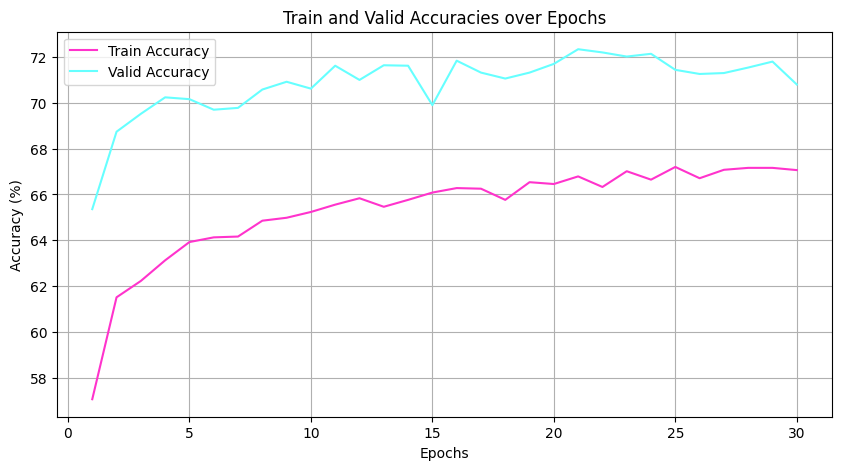

In [11]:
# Incremental Learner 생성
incremental_learner = IncrementalLearner(
    model,
    feature_extractor,
    lr=1e-2,
    momentum=0.9,
    weight_decay=3e-5,
    num_epochs=30,
    n_classes=10,
    temperature=1.9,
    alpha=0.825 # 키울 수록 old를 안 까먹으려고 할 것임. 이 값 조절이 포인트임.
)

# 새로운 데이터로 학습 시작
incremental_learner.train(train_loader, teacher_model, val_loader)

In [12]:
incremental_learner.save_state('mijin_incremental_learner.pth')

In [13]:
# Evaluate model performance
print("Final evaluation...")

print('--------------------------------------------')

total_accuracy, class_accuracies = incremental_learner.evaluate(test_loader)
print(f'Total Accuracy: {total_accuracy:.2f} %')

print('--------------------------------------------')

# Calculate average accuracy for old and new classes
old_class_avg_accuracy = np.mean([class_accuracies[i] for i in old_classes])
new_class_avg_accuracy = np.mean([class_accuracies[i] for i in new_classes])

print(f'Average Accuracy for old classes: {old_class_avg_accuracy:.2f} %')
print(f'Average Accuracy for new classes: {new_class_avg_accuracy:.2f} %')

print('--------------------------------------------')

# Print class-wise accuracy
for class_idx in range(incremental_learner.n_classes):
    print(f'Accuracy for class {class_idx}: {class_accuracies[class_idx]:.2f} %')
    
print('--------------------------------------------')


Final evaluation...
--------------------------------------------
Total Accuracy: 67.57 %
--------------------------------------------
Average Accuracy for old classes: 66.40 %
Average Accuracy for new classes: 68.74 %
--------------------------------------------
Accuracy for class 0: 45.20 %
Accuracy for class 1: 84.80 %
Accuracy for class 2: 70.10 %
Accuracy for class 3: 58.10 %
Accuracy for class 4: 73.80 %
Accuracy for class 5: 58.50 %
Accuracy for class 6: 71.00 %
Accuracy for class 7: 65.20 %
Accuracy for class 8: 83.10 %
Accuracy for class 9: 65.90 %
--------------------------------------------


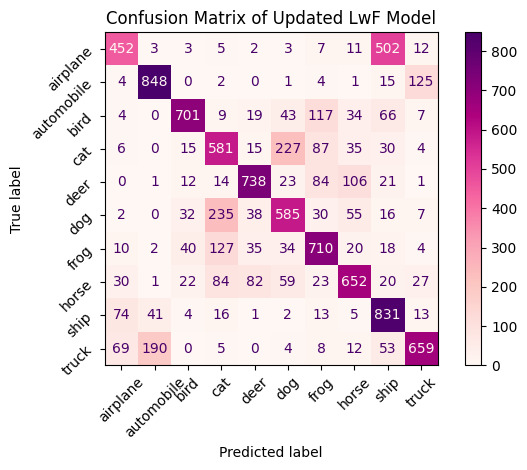

In [14]:

plot_confusion_matrix(model, test_loader, class_names, 'Confusion Matrix of Updated LwF Model')


In [15]:
from torchvision.transforms.functional import to_pil_image

def show_example_images(model, test_loader, class_names, num_images=5):
    model.eval()
    misclassified = []
    correctly_classified = []
    
    def unnormalize(img):
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        return img.clamp(0, 1)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            for input_img, label, prediction in zip(inputs, labels, predicted):
                if len(misclassified) < num_images and label != prediction:
                    misclassified.append((input_img.cpu(), label.cpu(), prediction.cpu()))
                if len(correctly_classified) < num_images and label == prediction:
                    correctly_classified.append((input_img.cpu(), label.cpu(), prediction.cpu()))
                if len(misclassified) >= num_images and len(correctly_classified) >= num_images:
                    break

    fig, axes = plt.subplots(2, num_images, figsize=(10, 5))
    for i in range(num_images):
        img, label, prediction = correctly_classified[i]
        img = unnormalize(img.squeeze())  # Unnormalize the image
        axes[0, i].imshow(to_pil_image(img))
        axes[0, i].set_title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
        axes[0, i].axis('off')

        img, label, prediction = misclassified[i]
        img = unnormalize(img.squeeze())  # Unnormalize the image
        axes[1, i].imshow(to_pil_image(img))
        axes[1, i].set_title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
        axes[1, i].axis('off')
    
    plt.show()

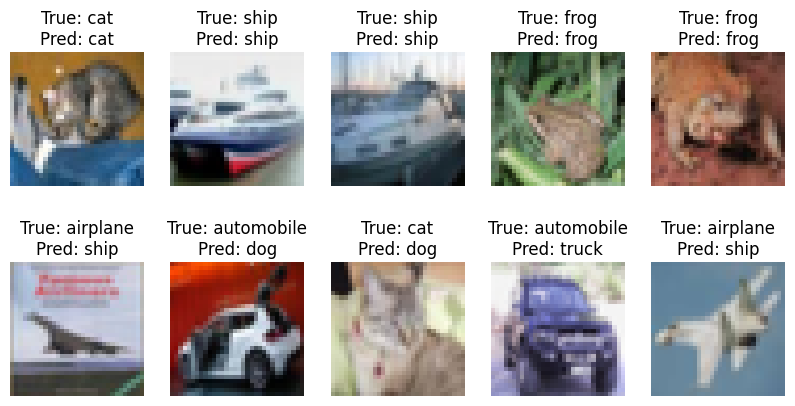

In [16]:


show_example_images(model, test_loader, class_names)



In [37]:
class PODNet(nn.Module):
    def __init__(self, base_model, num_classes, temp=1.0, num_proxies=10):
        super(PODNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])  # 최종 FC 레이어 제거
        self.num_proxies = num_proxies
        self.num_classes = num_classes
        self.temp = temp

        # Class proxies for LSC
        self.proxies = nn.Parameter(torch.randn(num_classes * num_proxies, 512))
        self.fc = nn.Linear(512, num_classes)

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.base_model(x)
        # print(f"Base model output shape: {features.shape}")  
        features = F.avg_pool2d(features, 4)  
        # print(f"Features after avg_pool2d: {features.shape}")  
        features = features.view(features.size(0), -1)
        # print(f"Features after view: {features.shape}")  
        outputs = self.fc(features) / self.temp
        # print(f"Outputs shape: {outputs.shape}") 
        return outputs, features

In [38]:
# Load pre-trained ResNet-18 with initial 5 classes
base_model = resnet18(num_classes=5)
base_model.load_state_dict(torch.load('resnet18_base.pth'))

# 기존 모델을 teacher model로 사용 (5개 클래스 상태에서 복사)
teacher_model = deepcopy(base_model)
teacher_model = teacher_model.to(device)  # teacher_model을 cuda로 이동
teacher_model.eval()

# Update the model's fully connected layer to 10 classes
base_model.fc = nn.Linear(base_model.fc.in_features, 10)
base_model = base_model.to(device)

# Feature extractor (removing the final classification layer)
feature_extractor = nn.Sequential(*list(base_model.children())[:-1]).to(device)

# PODNet 모델 정의
podnet_model = PODNet(base_model, num_classes=10)
podnet_model = podnet_model.to(device)

In [39]:
# Define a hook function to extract intermediate features
def get_intermediate_features(model, inputs):
    features = []
    hooks = []

    def hook(module, input, output):
        features.append(output)

    # Register hooks to extract features from specific layers
    for layer in model.children():
        if isinstance(layer, nn.Sequential):
            for sublayer in layer.children():
                hooks.append(sublayer.register_forward_hook(hook))
        else:
            hooks.append(layer.register_forward_hook(hook))

    # Forward pass to get features
    with torch.no_grad():
        model(inputs)

    # Remove hooks
    for h in hooks:
        h.remove()

    return features

class IncrementalLearnerPOD:
    def __init__(self, model, feature_extractor, lr=5e-5, momentum=0.9, weight_decay=2e-4, num_epochs=30, n_classes=10, temperature=2.0, alpha=0.5, scheduler_step_size=10, scheduler_gamma=0.1):
        self.model = model
        self.feature_extractor = feature_extractor
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.n_classes = n_classes
        self.temperature = temperature
        self.alpha = alpha
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.train_accuracies = []
        self.test_accuracies = []

        # Freeze feature extractor layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def distillation_loss(self, outputs, labels, teacher_outputs, alpha, temperature):
        """
        Compute the distillation loss given student outputs, ground truth labels, teacher outputs, alpha and temperature.
        """
        # Extend teacher outputs to match the new class size
        extended_teacher_outputs = torch.zeros_like(outputs)
        extended_teacher_outputs[:, :teacher_outputs.size(1)] = teacher_outputs

        loss = nn.KLDivLoss()(F.log_softmax(outputs / temperature, dim=1),
                              F.softmax(extended_teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature) + \
               F.cross_entropy(outputs, labels) * (1. - alpha)
        return loss

    def pod_loss(self, student_features, teacher_features):
        """
        Compute the POD loss given student and teacher features.
        """
        # Adjust teacher_features to match student_features shape
        teacher_features = F.avg_pool2d(teacher_features, 4)
        teacher_features = teacher_features.view(teacher_features.size(0), -1)
        # Calculate the POD loss
        pod_loss = F.mse_loss(student_features, teacher_features)
        return pod_loss

    def train(self, train_loader, teacher_model, val_loader):
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)

        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs, student_features = self.model(inputs)
                # print(f"Student features shape: {student_features.shape}") 

                # Get teacher model outputs and intermediate features
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)
                    teacher_features = get_intermediate_features(teacher_model, inputs)[-2]  # Use the second last feature map
                    # print(f"Teacher features shape: {teacher_features.shape}") 

                loss = self.distillation_loss(outputs, labels, teacher_outputs, self.alpha, self.temperature) + \
                       self.pod_loss(student_features, teacher_features)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if i % 100 == 99:
                    print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                    running_loss = 0.0

            train_accuracy = 100 * correct / total
            self.train_accuracies.append(train_accuracy)

            # Evaluate on test set
            print(f"Epoch {epoch + 1} complete. Evaluating...")
            test_accuracy, class_acc = self.evaluate(val_loader)
            self.test_accuracies.append(test_accuracy)
            print(f"Train Accuracy after epoch {epoch + 1}: {train_accuracy:.2f}%")
            print(f"Valid Accuracy after epoch {epoch + 1}: {test_accuracy:.2f}%")
            for class_idx in range(self.n_classes):
                print(f"Valid Accuracy for class {class_idx}: {class_acc[class_idx]:.2f}%")

            scheduler.step()

        self.plot_accuracies()
        return self.model


    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        class_correct = [0] * self.n_classes
        class_total = [0] * self.n_classes
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for label, prediction in zip(labels, predicted):
                    if label == prediction:
                        class_correct[label] += 1
                    class_total[label] += 1

        class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(self.n_classes)]
        return 100 * correct / total, class_acc

    def plot_accuracies(self):
        epochs = range(1, self.num_epochs + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy', color='#FF33CC')
        plt.plot(epochs, self.test_accuracies, label='Valid Accuracy', color='#66FFFF')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Train and Valid Accuracies over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

/home/compu/anaconda3/envs/MJ/lib/python3.12/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[1, 100] loss: 0.464
[1, 200] loss: 0.418
[1, 300] loss: 0.411
Epoch 1 complete. Evaluating...
Train Accuracy after epoch 1: 57.22%
Valid Accuracy after epoch 1: 58.92%
Valid Accuracy for class 0: 90.80%
Valid Accuracy for class 1: 33.40%
Valid Accuracy for class 2: 59.00%
Valid Accuracy for class 3: 63.80%
Valid Accuracy for class 4: 84.00%
Valid Accuracy for class 5: 29.60%
Valid Accuracy for class 6: 72.80%
Valid Accuracy for class 7: 55.40%
Valid Accuracy for class 8: 44.80%
Valid Accuracy for class 9: 55.60%
[2, 100] loss: 0.420
[2, 200] loss: 0.409
[2, 300] loss: 0.407
Epoch 2 complete. Evaluating...
Train Accuracy after epoch 2: 60.89%
Valid Accuracy after epoch 2: 65.76%
Valid Accuracy for class 0: 71.80%
Valid Accuracy for class 1: 54.60%
Valid Accuracy for class 2: 72.60%
Valid Accuracy for class 3: 56.20%
Valid Accuracy for class 4: 56.00%
Valid Accuracy for class 5: 55.40%
Valid Accuracy for class 6: 81.20%
Valid Accuracy for class 7: 66.60%
Valid Accuracy for class 8: 61.0

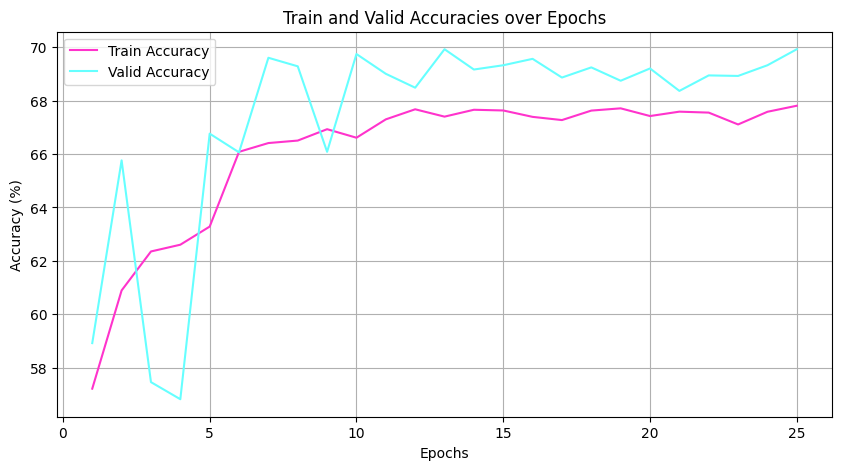

In [40]:
# Incremental Learner 생성 (PODNet)
incremental_learner_pod = IncrementalLearnerPOD(
    podnet_model,
    feature_extractor,
    lr=7e-2,
    momentum=0.9,
    weight_decay=5e-5,
    num_epochs=25,
    n_classes=10,
    temperature=2,
    alpha=0.825,  # 키울 수록 old를 안 까먹으려고 할 것임. 이 값 조절이 포인트임.
    scheduler_step_size = 5,
    scheduler_gamma= 0.2
)

# 새로운 데이터로 학습 시작 (PODNet)
final_model = incremental_learner_pod.train(train_loader, teacher_model, val_loader)


In [41]:
# 최종 모델 저장
torch.save(final_model.state_dict(), '2020142010.pth')
print("Model saved as final_model.pth")

Model saved as final_model.pth


In [42]:
# Evaluate model performance (PODNet)
print("Final evaluation (PODNet)...")
print('--------------------------------------------')

total_accuracy_pod, class_accuracies_pod = incremental_learner_pod.evaluate(test_loader)
print(f'Total Accuracy (PODNet): {total_accuracy_pod:.2f} %')

print('--------------------------------------------')

# Calculate average accuracy for old and new classes (PODNet)
old_class_avg_accuracy_pod = np.mean([class_accuracies_pod[i] for i in old_classes])
new_class_avg_accuracy_pod = np.mean([class_accuracies_pod[i] for i in new_classes])

print(f'Average Accuracy for old classes (PODNet): {old_class_avg_accuracy_pod:.2f} %')
print(f'Average Accuracy for new classes (PODNet): {new_class_avg_accuracy_pod:.2f} %')

print('--------------------------------------------')

# Print class-wise accuracy (PODNet)
for class_idx in range(incremental_learner_pod.n_classes):
    print(f'Accuracy for class {class_idx} (PODNet): {class_accuracies_pod[class_idx]:.2f} %')

print('--------------------------------------------')

Final evaluation (PODNet)...
--------------------------------------------
Total Accuracy (PODNet): 66.85 %
--------------------------------------------
Average Accuracy for old classes (PODNet): 66.42 %
Average Accuracy for new classes (PODNet): 67.28 %
--------------------------------------------
Accuracy for class 0 (PODNet): 62.70 %
Accuracy for class 1 (PODNet): 80.20 %
Accuracy for class 2 (PODNet): 64.80 %
Accuracy for class 3 (PODNet): 53.70 %
Accuracy for class 4 (PODNet): 70.70 %
Accuracy for class 5 (PODNet): 65.70 %
Accuracy for class 6 (PODNet): 72.00 %
Accuracy for class 7 (PODNet): 59.90 %
Accuracy for class 8 (PODNet): 70.20 %
Accuracy for class 9 (PODNet): 68.60 %
--------------------------------------------


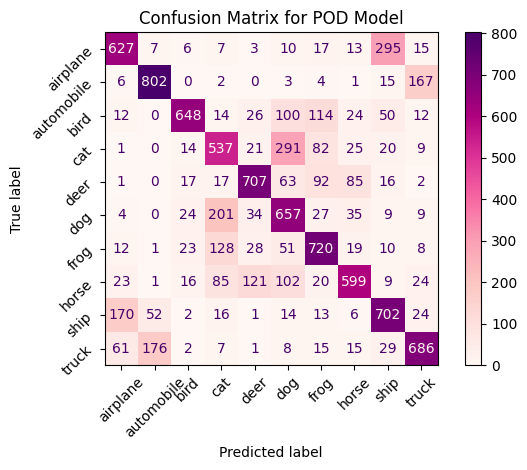

In [43]:
def plot_confusion_matrix(model, test_loader, class_names, title):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # 튜플일 경우 첫 번째 값을 사용
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.RdPu)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 최종 모델 성능 평가 및 혼동 행렬 시각화
plot_confusion_matrix(final_model, test_loader, class_names, "Confusion Matrix for POD Model")


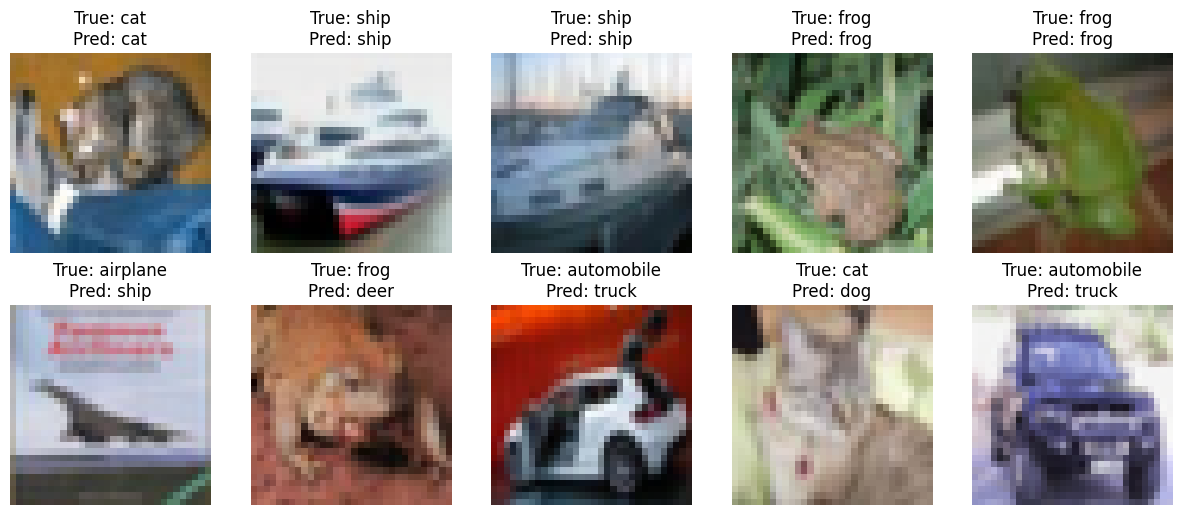

In [44]:
from torchvision.transforms.functional import to_pil_image
def show_example_images(model, test_loader, class_names, num_images=5):
    model.eval()
    misclassified = []
    correctly_classified = []

    def unnormalize(img):
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        return img.clamp(0, 1)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # 튜플일 경우 첫 번째 값을 사용
            _, predicted = torch.max(outputs.data, 1)
            for input_img, label, prediction in zip(inputs, labels, predicted):
                if len(misclassified) < num_images and label != prediction:
                    misclassified.append((input_img.cpu(), label.cpu(), prediction.cpu()))
                if len(correctly_classified) < num_images and label == prediction:
                    correctly_classified.append((input_img.cpu(), label.cpu(), prediction.cpu()))
                if len(misclassified) >= num_images and len(correctly_classified) >= num_images:
                    break

    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    for i in range(num_images):
        img, label, prediction = correctly_classified[i]
        img = unnormalize(img.squeeze())  # Unnormalize the image
        axes[0, i].imshow(to_pil_image(img))
        axes[0, i].set_title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
        axes[0, i].axis('off')

        img, label, prediction = misclassified[i]
        img = unnormalize(img.squeeze())  # Unnormalize the image
        axes[1, i].imshow(to_pil_image(img))
        axes[1, i].set_title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
        axes[1, i].axis('off')

    plt.show()


# 예제 이미지 시각화
show_example_images(final_model, test_loader, class_names, num_images=5)